In [1]:
import numpy as np, pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

Using TensorFlow backend.


In [7]:
import matplotlib.pyplot as plt

## 1.语料

In [2]:
path = r'datasets/'
comp = r'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE = r'models/glove.6B/glove.6B.50d.txt'
TRAIN_DATA_DIR = f'{path}{comp}train.csv'
TEST_DATA_DIR = f'{path}{comp}test.csv'

In [3]:
embed_size = 50
max_features = 20000
maxlen = 100  # 使用评论的前100个单词

train = pd.read_csv(TRAIN_DATA_DIR)
test = pd.read_csv(TEST_DATA_DIR)

查看语料数据

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


语料按类别的分布
- 评论中，恶意评论占比非常较少

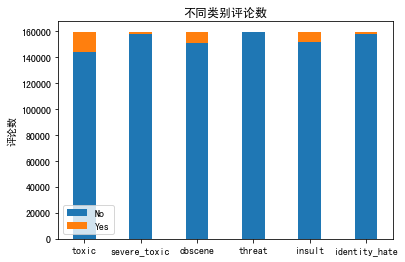

In [11]:
cats = train.columns[2:]

w = 0.4
x = np.arange(len(cats))
y1 = [len(train[train[cat]==0]) for cat in cats]
lab1 = 'No'

y2 = [len(train[train[cat]==1]) for cat in cats]
lab2 = 'Yes'

p1 = plt.bar(x, y1, w)
p2 = plt.bar(x, y2, w, bottom=y1)

plt.ylabel('评论数')
plt.title('不同类别评论数')
plt.xticks(x, cats)
plt.legend((p1[0], p2[0]),(lab1,lab2))
plt.show()

In [22]:
from functools import reduce
mask = reduce(lambda x, y: x & y, [(train[cat]==1) for cat in cats])
train[mask]['comment_text']

1017      WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...
1312      SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!
7299      You're a stupid cunt \n\nFuck you dumb arse, y...
13648     Bitch \n\nYou are a little bitch. I fuckin spe...
13964     I am going to murder ZimZalaBim ST47 for being...
22158     FUCK YOU!!!!!!!!!!!! YOU FUCKING NIGGER BAG OF...
29968     u motherfukkin bitch i want to rape you smelly...
32098     Fuck All Asyriac Nation \n\nQamishli belong to...
33951     GO FUCK YOURSELF BITCH.  I HATE YOUR SOULD.  M...
38513     AM GOING TO RAPE YOU IN THE ASS YOU FAT BITCH ...
38578     fuck you honkey, why you hatin' on blacks? You...
46155           So fuck off and die, rape fantasising sluts
55160     ANYONE WHO SUPPORTS THIS IS FUCKING SICK. MEN ...
59279     JEW \n\nGet the fuck out of here you jewish so...
65075     FAGGOTS!  YO FUCKER IT WAS FUCKING HAYES YOU F...
67247     YOURE A FRREAKING JEW, AND PLEAZE COMMIT SUICIDE.
73821     Shut up you asswipe, we don't 

语料单词数分布
- 不同评论间单词个数差别很大，最少小于5个单词，最多超过200个单词

In [32]:
import seaborn as sn

In [26]:
train['length']=train['comment_text'].apply(lambda x:len(x.split()))

In [30]:
median = train['length'].median()
mean = train['length'].mean()
mode = train['length'].mode()[0]

In [31]:
print(median, mean, mode)

36.0 67.27352714465661 5


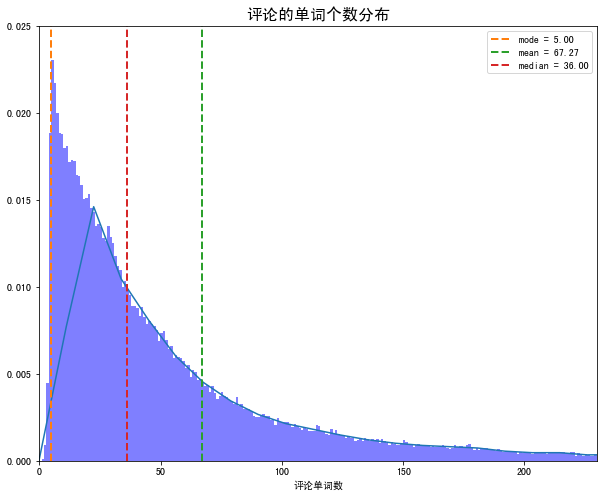

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sn.distplot(train['length'], bins=train['length'].max(),
            hist_kws={"alpha": 0.5, "color": "blue"}, ax=ax)
ax.set_xlim(left=0, right=np.percentile(train['length'], 95))
ax.set_xlabel('评论单词数')
ymax = 0.025
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=2)
ax.set_title('评论的单词个数分布', fontsize=16)
plt.legend()
plt.show()

In [82]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## 2.数据处理

In [139]:
list_sentences_train = train["comment_text"].fillna("_na_").values
list_sentences_test = test["comment_text"].fillna("_na_").values
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
                'identity_hate']

y_train = train[list_classes].values

In [36]:
embed_size = 50
max_features = 20000
maxlen = 100  # 使用每个评论的前100个单词

将评论分词并向量化

In [37]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [38]:
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [44]:
word_index = tokenizer.word_index

In [39]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   52, 2635,   13,  555, 3809,
         73, 4556, 2706,   21,   94,   38,  803, 2679,  992,  589, 8377,
        182])

In [43]:
train['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [42]:
X_train[10]

array([   9,    6,   40,   81,   22,    6,   18,  689,   61, 1401,  391,
       1347,    9,    6,   18, 1972,   92,  119,    4,  870,   88,  162,
          6,   40,  139,    5,  163,    3, 1401,    6,   18,  689,   32,
        423,   13,  164, 1219,    4, 4417,  340,   85,   16,  136,   48,
        714,  148,   51,   18,   55,  870,   17,  948,   15,  398,   12,
        254,  106,   22,    1,  118,    8, 1544,  177,    5,  280,  191,
       1087,  500,   28,  269,   81,   83,    1,  118,   44,   16,  136,
       1784,  773,  148,   22,    6,   18,   54,  235,   45,  209,   88,
         34,    1,  369,  246,  235,   27,  127,    6,   38,  248,  490,
        248])

In [50]:
train['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

## 3.使用 Glove 词向量

In [51]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

In [52]:
embedding_index = dict(get_coefs(*o.strip().split()) for o in
                       open(EMBEDDING_FILE, encoding='utf-8'))                                                                                                                                                                                                                                                  

In [53]:
all_embs = np.stack(embedding_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
print(emb_mean, emb_std)

D:\Program\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


0.020940498 0.6441043


In [54]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

In [55]:
word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [60]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
words_without_wv = 0
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        words_without_wv += 1
print("评论单词{}，没有词向量{:2.%}".format(len(word_index), words_without_wv))

评论单词210337，没有词向量1401


In [63]:
print("词汇表中{:.2%}单词没有词向量".format(words_without_wv/len(word_index)))

词汇表中0.67%单词没有词向量


In [61]:
embedding_matrix

array([[ 1.02822436,  0.16354269,  0.36796174, ..., -0.23140568,
        -0.75071671, -0.2013963 ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.68046999, -0.039263  ,  0.30186   , ..., -0.073297  ,
        -0.064699  , -0.26043999],
       ...,
       [-0.13491   , -0.8635    , -0.033898  , ...,  0.29484999,
        -0.24315999,  0.81682003],
       [ 0.1178    ,  0.14624   , -0.28240001, ..., -0.19529   ,
        -0.13610999,  1.04270005],
       [-0.64388001, -0.54152   ,  0.10305   , ..., -0.06732   ,
        -0.73308003,  0.88625002]])

## 4.训练模型

In [64]:
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [66]:
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 712s 5ms/step - loss: 0.0596 - acc: 0.9793 - val_loss: 0.0484 - val_acc: 0.9822
Epoch 2/2
143613/143613 [==============================] - 685s 5ms/step - loss: 0.0444 - acc: 0.9832 - val_loss: 0.0462 - val_acc: 0.9832


预测

In [83]:
y_test_pred = model.predict([X_test], batch_size=1024, verbose=1)

153164/153164 [==============================] - 42s 275us/step


In [85]:
y_test_pred[0]

array([0.99395025, 0.22166064, 0.9438987 , 0.01606953, 0.8902844 ,
       0.04045072], dtype=float32)

In [88]:
test.iloc[0]['comment_text']

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

## 5.TextCNN

In [133]:
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Reshape, Flatten

In [142]:
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Reshape((maxlen, embed_size, 1))(x)
x = Dropout(0.2)(x)

x_pooled = []
filters = 32
kernel_sizes = np.arange(1, 6)

for s in kernel_sizes:
    y = Conv2D(filters,
               kernel_size=(s, embed_size),
               padding='valid',
               activation='relu',
               strides=1)(x)
    y = MaxPooling2D(pool_size=(maxlen - s + 1, 1))(y)
    x_pooled.append(y)

x = Concatenate(axis=1)(x_pooled)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)

In [143]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [144]:
history = model.fit(X_train, y_train, batch_size=32, epochs=4, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 267s 2ms/step - loss: 0.0614 - acc: 0.9786 - val_loss: 0.0549 - val_acc: 0.9800
Epoch 2/4
143613/143613 [==============================] - 247s 2ms/step - loss: 0.0487 - acc: 0.9817 - val_loss: 0.0497 - val_acc: 0.9818
Epoch 3/4
143613/143613 [==============================] - 252s 2ms/step - loss: 0.0441 - acc: 0.9829 - val_loss: 0.0476 - val_acc: 0.9824
Epoch 4/4
143613/143613 [==============================] - 255s 2ms/step - loss: 0.0413 - acc: 0.9838 - val_loss: 0.0481 - val_acc: 0.9828


## 6.BiGRU+Pool

In [151]:
from keras.layers import SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, GRU

In [152]:
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(6, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [153]:
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 766s 5ms/step - loss: 0.0587 - acc: 0.9795 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 2/2
143613/143613 [==============================] - 652s 5ms/step - loss: 0.0446 - acc: 0.9831 - val_loss: 0.0458 - val_acc: 0.9830
